In [210]:
#run this script to install all the required packages
#!pip install -r requirements.txt

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [212]:
# Import Wartung.csv data

data = pd.read_csv('wartung.csv', sep=';', decimal=',', encoding='utf-8')

In [213]:
data.describe()

,MesswertID,Druck,Temperatur,Vibration,Anzahlwarning,Ausschuss,Produktionsindex
count,1095.000000,911.000000,9.170000e+02,9.150000e+02,1095.00000,803.000000,1095.000000
mean,13016.394521,3946.233329,2.581140e+04,5.926131e+04,2076.96347,2830.179328,89.797260
std,315.594610,54652.323534,3.518545e+05,6.459209e+05,34189.63800,39904.744680,6.074115
min,12478.000000,0.000000,0.000000e+00,0.000000e+00,1.00000,2.000000,80.000000
25%,12742.500000,47.619048,6.190476e+01,2.857143e+01,2.00000,3.000000,85.000000
50%,13016.000000,48.571429,6.285714e+01,3.809524e+01,5.00000,5.000000,90.000000
75%,13289.500000,61.904762,6.857143e+01,4.571429e+01,8.00000,7.000000,95.000000
max,13563.000000,848484.000000,5.465454e+06,8.486464e+06,566466.00000,566464.000000,100.000000


Hier muss noch eine Datenbank angebunden werden, um die Daten zu speichern.

Primary Key: ID, Datentypen müssen gegenenfalls noch angepasst werden nach der Preparation

## Datenaufbereiten

In [214]:
#Datentypen ausgeben
print("Datentypen:")
print(data.info())

Datentypen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1095 non-null   int64  
 1   MaschinenID       1095 non-null   object 
 2   Datum             1095 non-null   object 
 3   Zeit              1095 non-null   object 
 4   Druck             911 non-null    float64
 5   Temperatur        917 non-null    float64
 6   Vibration         915 non-null    float64
 7   Anzahlwarning     1095 non-null   int64  
 8   Ausschuss         803 non-null    float64
 9   Produktionsindex  1095 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 85.7+ KB
None


In [215]:
#Anzahl missing data
print("Datentypen:")
print(data.isnull().sum())

Datentypen:
MesswertID            0
MaschinenID           0
Datum                 0
Zeit                  0
Druck               184
Temperatur          178
Vibration           180
Anzahlwarning         0
Ausschuss           292
Produktionsindex      0
dtype: int64


In [216]:
#Datensätze mit Duplikaten entfernen
data.drop_duplicates(inplace=True)
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1095 non-null   int64  
 1   MaschinenID       1095 non-null   object 
 2   Datum             1095 non-null   object 
 3   Zeit              1095 non-null   object 
 4   Druck             911 non-null    float64
 5   Temperatur        917 non-null    float64
 6   Vibration         915 non-null    float64
 7   Anzahlwarning     1095 non-null   int64  
 8   Ausschuss         803 non-null    float64
 9   Produktionsindex  1095 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 85.7+ KB
None


In [217]:
print(data.head())

   MesswertID MaschinenID       Datum   Zeit      Druck  Temperatur  \
0       12478          A1  01.02.2022  06:00  47.619048   61.904762   
1       12479          A1  01.02.2022  06:05  48.571429   62.857143   
2       12480          A1  01.02.2022  06:10  57.142857   76.190476   
3       12481          A1  01.02.2022  06:15        NaN         NaN   
4       12482          A1  01.02.2022  06:20        NaN         NaN   

   Vibration  Anzahlwarning  Ausschuss  Produktionsindex  
0  28.571429              3        2.0                85  
1  47.619048              5        3.0                87  
2  33.333333             12       11.0                91  
3        NaN              2        NaN                84  
4        NaN              2        NaN                85  


### Fehlerhafte Daten  beim Datum identifizieren und korrigieren

In [218]:
# Convert date column to datetime format if value is not usable as date format remove them
data['Datum'] = pd.to_datetime(data['Datum'], format='%d.%m.%Y', errors='coerce').dt.date
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1095 non-null   int64  
 1   MaschinenID       1095 non-null   object 
 2   Datum             1086 non-null   object 
 3   Zeit              1095 non-null   object 
 4   Druck             911 non-null    float64
 5   Temperatur        917 non-null    float64
 6   Vibration         915 non-null    float64
 7   Anzahlwarning     1095 non-null   int64  
 8   Ausschuss         803 non-null    float64
 9   Produktionsindex  1095 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 85.7+ KB
None


In [219]:
print(data.head())

   MesswertID MaschinenID       Datum   Zeit      Druck  Temperatur  \
0       12478          A1  2022-02-01  06:00  47.619048   61.904762   
1       12479          A1  2022-02-01  06:05  48.571429   62.857143   
2       12480          A1  2022-02-01  06:10  57.142857   76.190476   
3       12481          A1  2022-02-01  06:15        NaN         NaN   
4       12482          A1  2022-02-01  06:20        NaN         NaN   

   Vibration  Anzahlwarning  Ausschuss  Produktionsindex  
0  28.571429              3        2.0                85  
1  47.619048              5        3.0                87  
2  33.333333             12       11.0                91  
3        NaN              2        NaN                84  
4        NaN              2        NaN                85  


In [220]:
# Convert Zeit column to time format if value is not usable as time format remove them
data['Zeit'] = pd.to_datetime(data['Zeit'], format='%H:%M', errors='coerce').dt.time
d1 = data

### Neue Spalten hinzufügen

In [221]:
# Add new Column 'Ausfall' with 0 or 1 for each row. Ausfall = 1 means Column Druck, Temperatur Vibration and Ausschuss are all NaN
d1['Ausfall'] = np.where( d1['Druck'].isnull() & d1['Temperatur'].isnull() & d1['Vibration'].isnull() & d1['Ausschuss'].isnull(), 1, 0)
print(d1.head(10))
d2 = d1

   MesswertID MaschinenID       Datum      Zeit      Druck  Temperatur  \
0       12478          A1  2022-02-01  06:00:00  47.619048   61.904762   
1       12479          A1  2022-02-01  06:05:00  48.571429   62.857143   
2       12480          A1  2022-02-01  06:10:00  57.142857   76.190476   
3       12481          A1  2022-02-01  06:15:00        NaN         NaN   
4       12482          A1  2022-02-01  06:20:00        NaN         NaN   
5       12483          A1  2022-02-01  06:25:00        NaN         NaN   
6       12484          A1  2022-02-01  06:30:00        NaN         NaN   
7       12485          A1  2022-02-01  06:35:00        NaN         NaN   
8       12486          A1  2022-02-01  06:40:00        NaN         NaN   
9       12487          A1  2022-02-01  06:45:00        NaN         NaN   

   Vibration  Anzahlwarning  Ausschuss  Produktionsindex  Ausfall  
0  28.571429              3        2.0                85        0  
1  47.619048              5        3.0           

In [222]:
# if one of druck, vibration or temperatur is NaN and Ausfall = 0 then new column 'Error' = 1
d2['Error'] = np.where((d2['Ausfall'] == 0) & (d2['Druck'].isnull() | d2['Temperatur'].isnull() | d2['Vibration'].isnull()), 1, 0)


In [223]:
#count the number of errors
print(d2['Error'].value_counts())

Error
0    1075
1      20
Name: count, dtype: int64


In [224]:
#20 errors können gelöscht werden, da unter 1% der Daten
d2 = d2[d2['Error'] == 0]
d2 = d2.drop(['Error'], axis=1)
print(d2.info())


<class 'pandas.core.frame.DataFrame'>
Index: 1075 entries, 0 to 1094
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1075 non-null   int64  
 1   MaschinenID       1075 non-null   object 
 2   Datum             1066 non-null   object 
 3   Zeit              1066 non-null   object 
 4   Druck             901 non-null    float64
 5   Temperatur        901 non-null    float64
 6   Vibration         901 non-null    float64
 7   Anzahlwarning     1075 non-null   int64  
 8   Ausschuss         785 non-null    float64
 9   Produktionsindex  1075 non-null   int64  
 10  Ausfall           1075 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 96.6+ KB
None


In [225]:
#In der Datumsspalte gibt es leere Werte da diese nicht in einem gültigen Format sind. Diese Zeilen können gelöscht werden, da sie nur 0,1% der Daten ausmachen (alternativ könnte man die Annahme treffen, dass diese, da am ende dem 08.02. zugeordnet werden können (input))
d2 = d2.dropna(subset=['Datum'])
print(d2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1066 entries, 0 to 1085
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1066 non-null   int64  
 1   MaschinenID       1066 non-null   object 
 2   Datum             1066 non-null   object 
 3   Zeit              1066 non-null   object 
 4   Druck             892 non-null    float64
 5   Temperatur        892 non-null    float64
 6   Vibration         892 non-null    float64
 7   Anzahlwarning     1066 non-null   int64  
 8   Ausschuss         776 non-null    float64
 9   Produktionsindex  1066 non-null   int64  
 10  Ausfall           1066 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 95.8+ KB
None


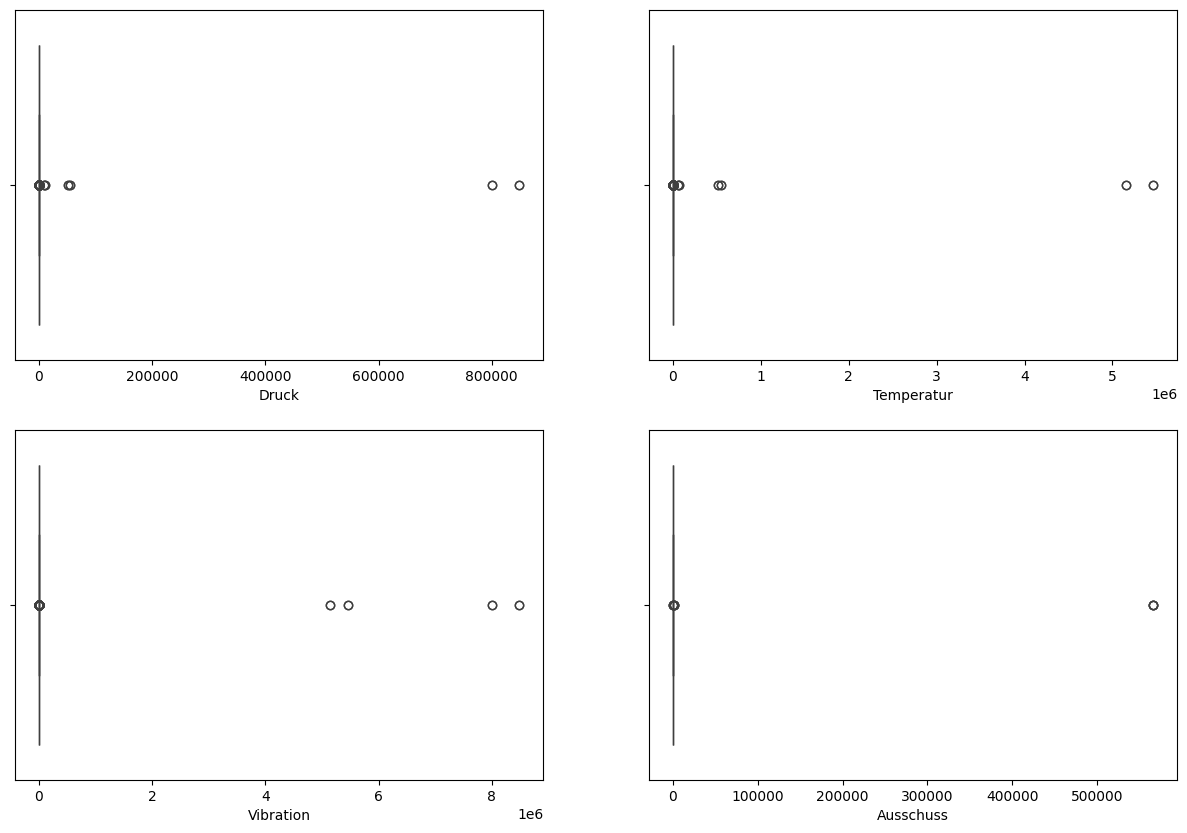

In [226]:
#Ausreiser erkennen für Druck, Temperatur, Vibration und Ausschuss in einem boxplot mit seaborn
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.boxplot(x=d2['Druck'], ax=ax[0,0])
sns.boxplot(x=d2['Temperatur'], ax=ax[0,1])
sns.boxplot(x=d2['Vibration'], ax=ax[1,0])
sns.boxplot(x=d2['Ausschuss'], ax=ax[1,1])
plt.show()

In [227]:
d2.describe()
d2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1066 entries, 0 to 1085
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1066 non-null   int64  
 1   MaschinenID       1066 non-null   object 
 2   Datum             1066 non-null   object 
 3   Zeit              1066 non-null   object 
 4   Druck             892 non-null    float64
 5   Temperatur        892 non-null    float64
 6   Vibration         892 non-null    float64
 7   Anzahlwarning     1066 non-null   int64  
 8   Ausschuss         776 non-null    float64
 9   Produktionsindex  1066 non-null   int64  
 10  Ausfall           1066 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 95.8+ KB


In [228]:
#ausreißer entfernen druck über 100 aber leere behalten
d2 = d2[(d2['Druck'] < 100) | (d2['Druck'].isnull())]
d2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1054 entries, 0 to 1085
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1054 non-null   int64  
 1   MaschinenID       1054 non-null   object 
 2   Datum             1054 non-null   object 
 3   Zeit              1054 non-null   object 
 4   Druck             880 non-null    float64
 5   Temperatur        880 non-null    float64
 6   Vibration         880 non-null    float64
 7   Anzahlwarning     1054 non-null   int64  
 8   Ausschuss         764 non-null    float64
 9   Produktionsindex  1054 non-null   int64  
 10  Ausfall           1054 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 94.7+ KB


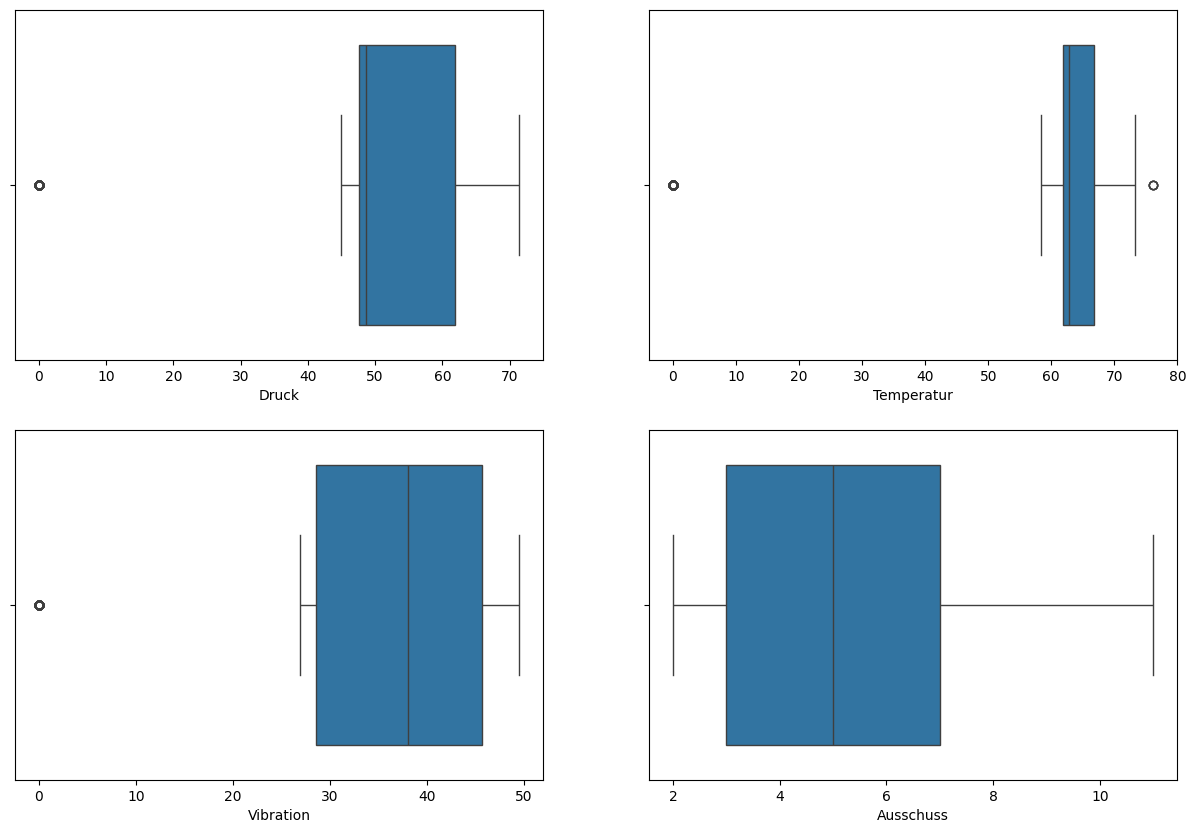

In [229]:
#Ausreißer überprüfen
fig, ax = plt.subplots(2,2, figsize=(15,10))
sns.boxplot(x=d2['Druck'], ax=ax[0,0])
sns.boxplot(x=d2['Temperatur'], ax=ax[0,1])
sns.boxplot(x=d2['Vibration'], ax=ax[1,0])
sns.boxplot(x=d2['Ausschuss'], ax=ax[1,1])
plt.show()

Gegebenenfalls können anstelle von Entfernen auch Werte durch synthetische Daten ersetzt werden

In [230]:
#creating requirements.txt
#!pip freeze > requirements.txt

### Daten die NaN sind durch 0 ersetzen und in d3 speichern

In [231]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1054 entries, 0 to 1085
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MesswertID        1054 non-null   int64  
 1   MaschinenID       1054 non-null   object 
 2   Datum             1054 non-null   object 
 3   Zeit              1054 non-null   object 
 4   Druck             880 non-null    float64
 5   Temperatur        880 non-null    float64
 6   Vibration         880 non-null    float64
 7   Anzahlwarning     1054 non-null   int64  
 8   Ausschuss         764 non-null    float64
 9   Produktionsindex  1054 non-null   int64  
 10  Ausfall           1054 non-null   int32  
dtypes: float64(4), int32(1), int64(3), object(3)
memory usage: 94.7+ KB


In [232]:
d3 = d2[['Druck', 'Vibration', 'Temperatur', 'Ausschuss', 'Produktionsindex']].fillna(0)

In [233]:
d3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1054 entries, 0 to 1085
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Druck             1054 non-null   float64
 1   Vibration         1054 non-null   float64
 2   Temperatur        1054 non-null   float64
 3   Ausschuss         1054 non-null   float64
 4   Produktionsindex  1054 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 49.4 KB


## Datenanalyse

Datenanalyse mit Klassifikationsmodell auf die Zielvariable Ausfall

Import benötigter Pakete:

In [234]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

Aufteilung der Daten in Trainings- und Testdaten von d2:


In [235]:
X1 = d2[['Druck', 'Vibration', 'Temperatur', 'Ausschuss', 'Produktionsindex']]
y1 = d2['Ausfall']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

Aufteilung der Daten in Trainings- und Testdaten von d3:

In [236]:
X2 = d3[['Druck', 'Vibration', 'Temperatur', 'Ausschuss', 'Produktionsindex']]
y2 = d2['Ausfall']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

### Modellbildung mit Gradient boost:

In [237]:
# Initialisierung des Modells
model = HistGradientBoostingClassifier()

# Anpassung des Modells an die Trainingsdaten
model.fit(X1_train, y1_train)

# Vorhersagen auf den Testdaten
y1_pred = model.predict(X1_test)

Bewertung des Modells Gradient Boost:

In [238]:
accuracy = accuracy_score(y1_test, y1_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


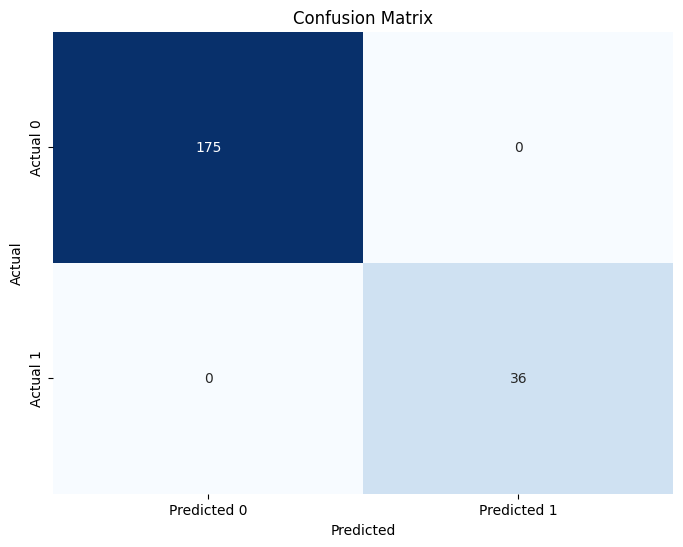

In [239]:
# Darstellung der Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Modellbildung mit Random Forrest: 

Hier wurden alle Daten durch 0 ersetzt weil weil das Modell nicht mit NaN werten arbeiten kann

In [240]:
# Initialisierung des Modells
model = RandomForestClassifier()

# Anpassung des Modells an die Trainingsdaten
model.fit(X2_train, y2_train)

# Vorhersagen auf den Testdaten
y2_pred = model.predict(X2_test)

In [241]:
accuracy = accuracy_score(y1_test, y1_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 1.0


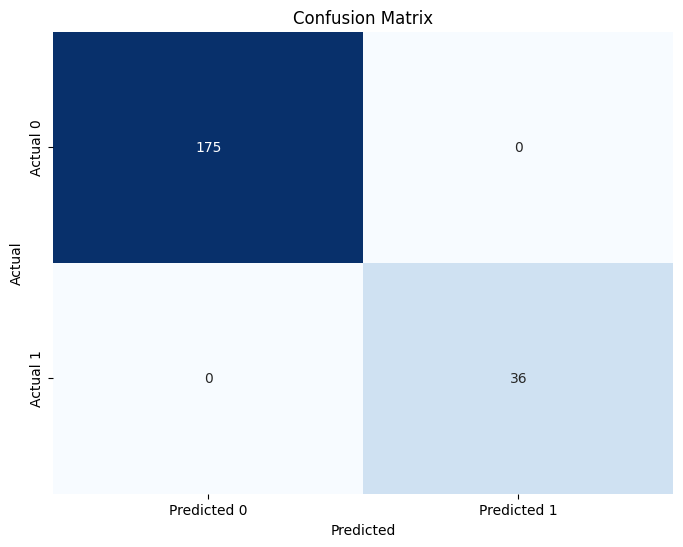

In [242]:
# Darstellung der Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()